In [1]:
import sys
import yaml
import itertools

import astropy.units as u
import astropy.time

import drms
import sunpy.map
from sunpy.util import MetaDict
import sunpy.io.fits
import astropy.io.fits
import matplotlib.pyplot as plt
import dask
import dask.array as da
import distributed
from dask_jobqueue import PBSCluster
import numpy as np
from skimage.filters import median
from skimage.morphology import closing, disk, square, white_tophat
from skimage.util import invert
from skimage.measure import label, regionprops, regionprops_table
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, Box1DKernel
#from astropy.visualization import time_support
from astropy.table import QTable, vstack

sys.path.append('../scripts/')
from drms_on_ames import Client

# Finding Sunspots in HMI Continuum Data with STARA

## Will Barnes, Stuart Mumford, Fraser Watson

In this notebook, we'll apply the Sunspot Tracking And Recognition Algorithm (STARA) of [Fraser et al. (2009)](https://ui.adsabs.harvard.edu/link_gateway/2009SoPh..260....5W/doi:10.1007/s11207-009-9420-z) to all HMI continuum images, sampled at a 1 day cadence, from the start of the SDO mission until now (Noveber 2019). While this algorithm, and other sunspot identification algorithms, have been applied to similar data volumes in the past, the speed at which we can now do this allows for exploratory calculations on large datasets that would not have otherwise been possible.

## Configure Dask Cluster

First, spin up a Dask cluster with a reasonable number of workers such that we can process the whole catalogue in approximately 10 minutes or less.

In [2]:
with open('../jobqueue-merope.yml','r') as f:
    config = yaml.load(f)['jobqueue']['pbs']

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [3]:
cluster = PBSCluster(**config)

In [4]:
client = distributed.Client(cluster)

In [5]:
client

<Client: 'tcp://10.152.4.0:41049' processes=0 threads=0, memory=0 B>

In [7]:
cluster.scale(50)

## Querying HMI Continuum and Magnetogram Data

Next, we'll query DRMS for both the HMI continuum images as well as the contemporaneous magnetogram data. We'll apply the sunspot finding algorithm to the former and use the latter to extract the magnetic flux associated with each sunspot.

In [8]:
c = Client(ssh=True)

In [9]:
# These are the keys we need to construct a proper map.
keys_drms = [
    'DATE__OBS',
    'TELESCOP',
    'INSTRUME',
    'WAVELNTH', 
    'BUNIT',
    'CTYPE1',
    'CTYPE2',
    'CRPIX1',
    'CRPIX2',
    'CRVAL1',
    'CRVAL2',
    'CDELT1',
    'CDELT2',
    'CUNIT1',
    'CUNIT2',
    'CROTA2',
    'WCSNAME',
    'DSUN_OBS',
    'DSUN_REF', 
    'RSUN_REF',
    'CRLN_OBS', 
    'CRLT_OBS', 
    'CAR_ROT',
    'RSUN_OBS', 
    'T_OBS',
    'T_REC',
]

In [10]:
keys_continuum,files_continuum = c.query(
    'hmi.ic_720s[2010-01-01T00:00:00_TAI/3600d@1d]',
    seg=['continuum'],
    key=keys_drms,
)

../scripts/drms_on_ames.py:57: UserWarning: 
-------------------------------------------------------------------------

By accessing and using this information system, you acknowledge and
consent to the following:

You are accessing a U.S. Government information system, which includes:
(1) this computer; (2) this computer network; (3) all computers connected
to this network including end user systems; (4) all devices and storage
media attached to this network or to any computer on this network; and
(5) cloud and remote information services. This information system is
provided for U.S. Government-authorized use only. You have no reasonable
expectation of privacy regarding any communication transmitted through or
data stored on this information system.  At any time, and for any lawful
purpose, the U.S. Government may monitor, intercept, search, and seize
any communication or data transiting, stored on, or traveling to or from
this information system.  You are NOT authorized to process cl

In [11]:
keys_magnetogram,files_magnetogram = c.query(
    'hmi.m_720s[2010-01-01T00:00:00_TAI/3600d@1d]',
    seg=['magnetogram'],
    key=keys_drms,
)

## Load Continuum Images and Magnetograms as `Map`s

The files have not been properly exported such that the image data have missing/incorrect headers. We need to first construct a proper header from each row in the keyword table, read in the image data from the file, and then combine these two into a `sunpy.map.Map` object.

In [12]:
def get_headers(keys):
    headers = []
    for i,row in keys.iterrows():
        header = MetaDict({k:row[k] for k in keys.columns if k != 'SOURCE'})
        header['DATE_OBS'] = header['DATE__OBS']
        headers.append(header)
    return headers

In [13]:
def get_data(file):
    return sunpy.io.fits.read(file)[1].data

First, construct the continuum maps

In [14]:
headers = get_headers(keys_continuum)
# Sometimes a query can return a directory name; remove those
files_filtered = [f for f in files_continuum['continuum'] if '.fits' in f]
headers = [h for f,h in zip(files_continuum['continuum'],headers) if '.fits' in f]

In [15]:
arrays = client.map(get_data, files_filtered)

In [16]:
maps_continuum = client.map(sunpy.map.Map, arrays, headers)

Then, make the magnetogram maps

In [17]:
headers = get_headers(keys_magnetogram)
files_filtered = [f for f in files_magnetogram['magnetogram'] if '.fits' in f]
headers = [h for f,h in zip(files_magnetogram['magnetogram'],headers) if '.fits' in f]

In [18]:
arrays = client.map(get_data, files_filtered)

In [19]:
maps_magnetogram = client.map(sunpy.map.Map, arrays, headers)

Let's plot a single continuum image and magnetogram to make sure we've correctly 

In [20]:
m_continuum = client.gather(maps_continuum[1500])
m_magnetogram = client.gather(maps_magnetogram[1500])

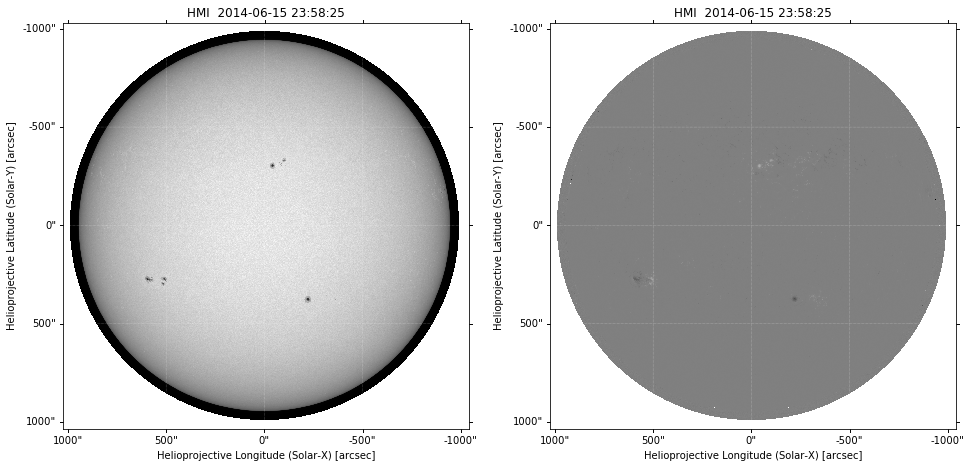

In [21]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection=m_continuum)
m_continuum.plot(axes=ax)
ax = fig.add_subplot(122, projection=m_magnetogram)
m_magnetogram.plot(axes=ax)

## Finding Sunspots

Now that we've acquired the necessary data and coerced each observation into a `Map`, we're ready to apply the STARA algorithm to each image. Below is a Python implementation of STARA that relies on the widely-used [scikit-image package](https://scikit-image.org/) for all of the image processing tasks. This algorithm will be merged into [sunkit-image](https://github.com/sunpy/sunkit-image) at a later date.

In [22]:
@u.quantity_input
def stara(smap, circle_radius: u.deg = 100*u.arcsec, median_box: u.deg = 10*u.arcsec,
          threshold=6000, limb_filter: u.percent = None):
    data = invert(smap.data)

    # Filter things that are close to limb to reduce false detections
    if limb_filter is not None:
        hpc_coords = sunpy.map.all_coordinates_from_map(smap)
        r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / (smap.rsun_obs - smap.rsun_obs * limb_filter)
        data[r>1] = np.nan

    # Median filter to remove detections based on hot pixels
    m_pix = int((median_box / smap.scale[0]).to_value(u.pix))
    med = median(data, square(m_pix), behavior="ndimage")

    # Construct the pixel structuring element
    c_pix = int((circle_radius / smap.scale[0]).to_value(u.pix))
    circle = disk(c_pix/2)

    filtered = white_tophat(med, circle,)
    filtered[np.isnan(filtered)] = 0  # Filter out nans

    return filtered > threshold

Let's apply this to the example images from above. First, we'll resample the continuum image as running the algorithm on the full-resolution image can be computationally expensive and not strictly necessary.

In [23]:
m_continuum_resample = m_continuum.resample((1024,1024)*u.pixel)

Finally, apply the algorithm to the image. The result, `seg`, is a boolean array where pixels are marked as True if they fall inside a sunspot and are set to False otherwise.

In [24]:
seg = stara(m_continuum_resample,limb_filter=10*u.percent)

Let's plot the contours of the sunspots on top of both the continuum image and magnetogram.

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


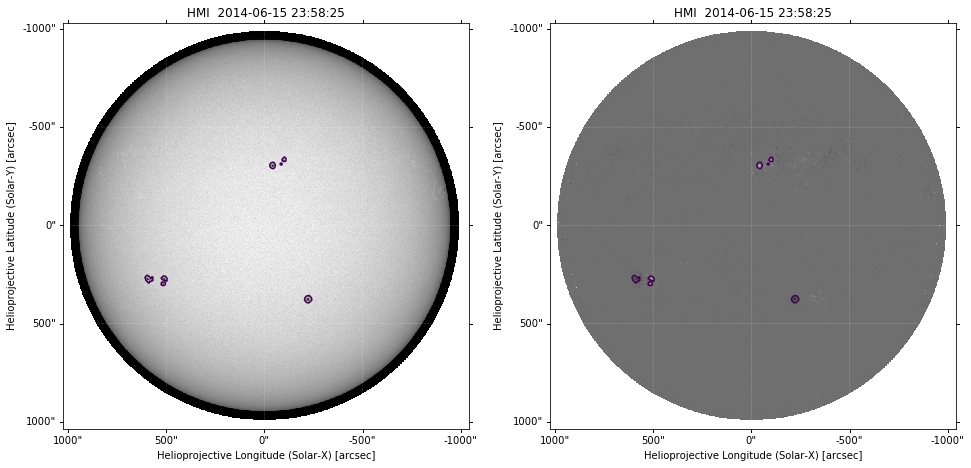

In [25]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection=m_continuum_resample)
m_continuum_resample.plot(axes=ax)
ax.contour(seg,levels=0)
m_magnetogram_resample = m_magnetogram.resample((1024,1024)*u.pixel)
ax = fig.add_subplot(122, projection=m_magnetogram_resample)
m_magnetogram_resample.plot(axes=ax)
ax.contour(seg,levels=0)

Now that we've seen it works for one image, let's resample all of the continuum images and apply the sunspot finding algorithm to a continuum image from every day between the start of the SDO mission and now.

In [26]:
maps_continuum_resampled = client.map(
    lambda x: x.resample((1024, 1024) * u.pix), maps_continuum,
)

In [27]:
segs = client.map(stara, maps_continuum_resampled,
                  limb_filter=10*u.percent)

## Creating a Sunspot Database

We now have a boolean sunspot mask for each of the images in our series, but what is the best way to aggregate all of this data? The scikit image library provides several bits of functionality for dealing with simply connected regions in images, namely the [`label`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label) and [`regionprops_table`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops_table) functions. The former labels regions whose pixels are connected and the latter computes properties (e.g. area, centroid) of each of these regions and formats these properties as a table.

From these properties, we can also compute the longitude and latitude of the centroid of each sunspot using the coordinate information attached to the map. Given a STARA mask, a continuum image, and a magnetogram, the following function returns a table of properties, including magnetic flux as determined from the magnetogram, for each spot identified in the mask.

In [28]:
def get_regions(seg, m_continuum, m_magnetogram):
    labelled = label(seg)
    if labelled.max() == 0:
        return QTable()

    regions = regionprops_table(
        labelled,
        m_continuum.data,
        properties=[
            "label",
            "centroid",
            "area",
            "min_intensity",
            "bbox",
            "image",
        ]
    )
    
    regions = QTable(regions)
    regions['obstime'] = astropy.time.Time([m_continuum.date] * regions['label'].size)
    coord = m_continuum.pixel_to_world(
        regions['centroid-1'] * u.pix,
        regions['centroid-0'] * u.pix).heliographic_stonyhurst
    regions['center_lon'] = coord.lon
    regions['center_lat'] = coord.lat
    regions['center_rad'] = coord.radius
    
    flux = []
    for y0,x0,mask,area in regions[['bbox-0','bbox-1','image','area']]:
        y,x = np.where(mask)
        flux.append(m_magnetogram.data[(y+y0,x+x0)].sum() / area)
    regions['flux'] = flux * u.Unit(m_magnetogram.meta['bunit'])

    return regions

Let's resample the magnetograms to the same resolution as the continuum images

In [29]:
maps_magnetogram_resampled = client.map(
    lambda x: x.resample((1024, 1024) * u.pix), maps_magnetogram,
)

And then create a table of region properties for each sunspot mask and resampled continuum image and magnetogram.

In [30]:
regions = client.map(get_regions, segs, maps_continuum_resampled, maps_magnetogram_resampled)

We'll then bring all of these tables back into the memory of the notebook (from the cluster)

In [31]:
region_tables = client.gather(regions)

And stack them such that we have a single table with details about every sunspot we identified over the interval spanning the lifetime of the SDO mission.

In [32]:
region_table = vstack([t for t in region_tables if len(t) > 0])

## Visualization

We can visualize this data in several different ways. The first and possibly most obvious way is simply to count the number of spots that occurred in each image. We'll bin our sunspot counts into one month bins:

In [33]:
delta_time = region_table['obstime'] - region_table['obstime'][0]
spots,bins = np.histogram(delta_time.to(u.day).value,
                          bins=np.arange(0,delta_time[-1].value+1,30),)
time_spots = (bins[1:] + bins[:-1])/2*u.day + region_table['obstime'][0]

And then smooth the time series over 6 months.

In [34]:
kernel = Box1DKernel(6)
spots_smooth = convolve(spots, kernel)

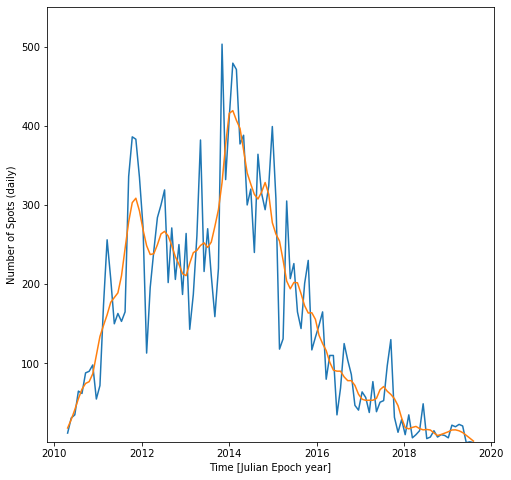

In [35]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.plot(time_spots.jyear, spots,)
ax.plot(time_spots.jyear, spots_smooth)
ax.set_ylabel('Number of Spots (daily)');
ax.set_xlabel(f'Time [Julian Epoch year]');
ax.set_ylim(1,550);

We can also make a so-called "butterfly diagram" by plotting the latitude for ever identified spot as a function of time.

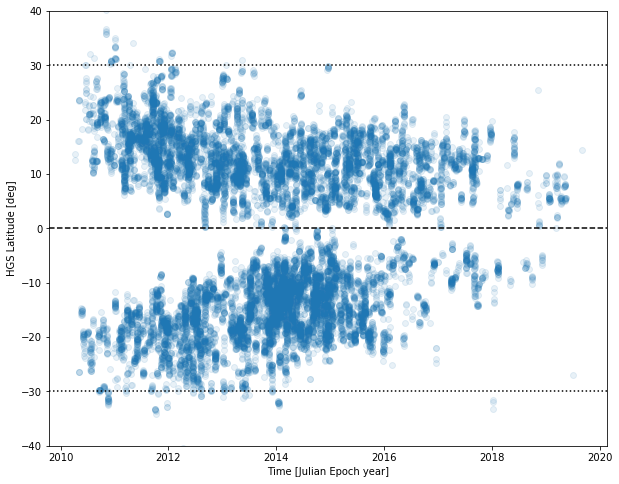

In [36]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(region_table['obstime'].jyear,
           region_table['center_lat'],
           marker='o',
           alpha=0.1,
          )
ax.axhline(y=0, ls='--', color='k')
ax.axhline(y=-30, ls=':',color='k');
ax.axhline(y=+30, ls=':',color='k');
ax.set_ylim(-40,40)
ax.set_xlabel(f'Time [Julian Epoch year]');
ax.set_ylabel(f'HGS Latitude [{region_table["center_lat"].unit}]');

Furthermore, because we also included the magnetogram information, we can weight each point by the average magnetic field strength in each spot. The origin of the strange discontinuity around 2015 is not clear...

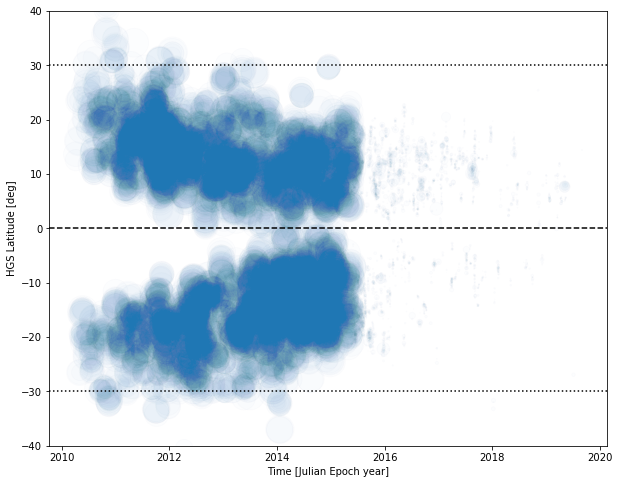

In [43]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(region_table['obstime'].jyear,
           region_table['center_lat'],
           s=np.abs(region_table['flux'].to(u.G).value),
           marker='o',
           alpha=0.01,
          )
ax.axhline(y=0, ls='--', color='k')
ax.axhline(y=-30, ls=':',color='k');
ax.axhline(y=+30, ls=':',color='k');
ax.set_ylim(-40,40)
ax.set_xlabel(f'Time [Julian Epoch year]');
ax.set_ylabel(f'HGS Latitude [{region_table["center_lat"].unit}]');

Additionally, we can also look at distributions of things like the area

(0.75, 10000.0)

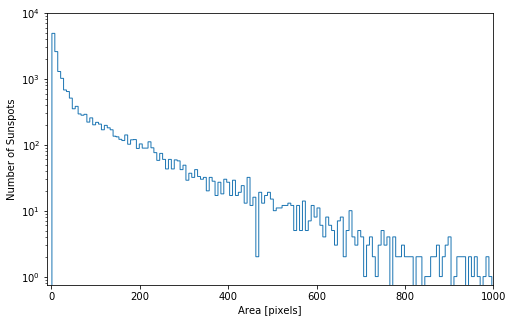

In [44]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax.hist(region_table['area'],
        bins='fd',
        histtype='step',
        log=True);
ax.set_xlabel(f'Area [pixels]');
ax.set_ylabel('Number of Sunspots');
ax.set_xlim(-10,1000)
ax.set_ylim(0.75,1e4)

Or the average field strength (times the area)

(0.75, 10000.0)

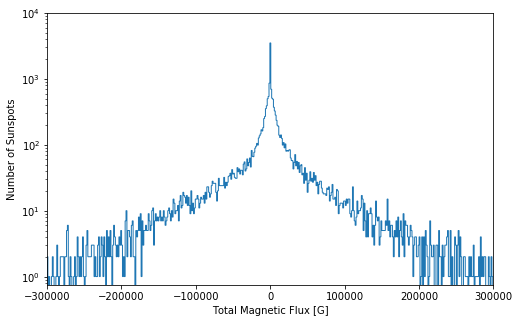

In [47]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax.hist(region_table['flux'].to(u.G).value * region_table['area'],
        bins='fd',
        histtype='step',
        log=True);
ax.set_xlabel(f'Total Magnetic Flux [G]');
ax.set_ylabel('Number of Sunspots');
ax.set_xlim(-3e5,3e5)
ax.set_ylim(0.75,1e4)